# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'

In [5]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [6]:
def regress(ax, p, data, t_label=20, color='k', lw=2, axis=None) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    if axis is None :
        x1, x2 = np.min(p), np.max(p)
        y1, y2 = np.min(data), np.max(data)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [7]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=20, color='k', lw=2, axis=None) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    def m(x, w):
        """Weighted Mean"""
        return np.sum(x * w) / np.sum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

    def corr(x, y, w):
        """Weighted Correlation"""
        return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    
    if axis is None :
        x1, x2 = np.min(x), np.max(x)
        y1, y2 = np.min(y), np.max(y)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    
    
    
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


In [8]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [9]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

list_suj = {'AM': 'F', 'BMC': 'M', 'CS': 'F', 'DC': 'F',
            'FM': 'F', 'IP': 'F',  'LB': 'F', 'OP': 'M',
            'RS': 'M', 'SR': 'F',  'TN': 'M', 'YK': 'M'}

In [10]:
def plot_fig(recording) :
    
    #fig, ax = plt.subplots(3,1,figsize=(15,20))
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:]
    COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    
    fig = plt.figure(figsize=(15,15))
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(6, 6)
    ax_ = plt.subplot(gs[1:5, :4])
    ax_x = plt.subplot(gs[0, :4])#,sharex=ax_)
    ax_y = plt.subplot(gs[1:5, 4])#,sharey=ax_)

    ax_xCum = ax_x.twinx() ; ax_xCum.tick_params('y', colors='r') ; ax_xCum.set_ylabel('cumulative',color='r')
    ax_yCum = ax_y.twiny() ; ax_yCum.tick_params('x', colors='r') ; ax_yCum.set_xlabel('cumulative',color='r')
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xCum] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yCum] : a.set_ylim(lim) ; a.set_yticks(())
    
    
    # DECO
    #---------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '--k')
    ax_.vlines(0.025, 0, 0.025, colors='k') ; ax_.hlines(0.025, 0, 0.025, colors='k')
    ax_.set_xlabel('$h_{va}$', fontsize=20) ; ax_.set_ylabel('$h_{bet}$', fontsize=20)
    
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    #---------------------------------------------------------------
    h_va, h_bet = {'full':[], 'F':[], 'M':[]}, {'full':[], 'F':[], 'M':[]}
    r_va, r_bet = {'full':[], 'F':[], 'M':[]}, {'full':[], 'F':[], 'M':[]}
    
    
    for num, s in enumerate(suj) :
        if list_suj[s]=='F' : coco='r'
        else :                coco='b'
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            

            r_va_d, r_bet_d = recording['r_va'][s][d][:], recording['r_bet'][s][d][:]

            h_va_s.append(list_h[np.argmax(r_va_d)]) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
            r_va_s.append(np.max(r_va_d)) ; r_bet_s.append(np.max(r_bet_d))

        opt = dict(c=COLOR[num], alpha=0.5, lw=2, edgecolors=coco,) 
        ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*400,
                    marker='*' if s in ['TN', 'LB'] else None, **opt)
        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*400, **opt)

        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)


        h_va[list_suj[s]].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
        h_bet[list_suj[s]].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
        r_va[list_suj[s]].extend(r_va_s)
        r_bet[list_suj[s]].extend(r_bet_s)
        
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])


    axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100,
              min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
    
    opt = dict(t_label=20, color='k', lw=2, axis=axis_r)
    ax_ = regress(ax_, np.log(h_bet['full']), np.log(h_va['full']), **opt)
    ax_ = r_weight(ax_, np.log(h_bet['full']), np.log(h_va['full']), r_va['full']*r_bet['full'], **opt)

    

    #-------------------------------------------------------------------------------------
    range_his = (np.log(min(list_h)), np.log(max(list_h)))
    bins_his=20

    opt = dict(range=range_his, bins=bins_his, alpha=0.3)
    ax_x.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt)
    ax_x.hist([np.log(h_va['F']), np.log(h_va['M'])], weights=[r_va['F'], r_va['M']], color=['r', 'b'], **opt)

    opt['orientation'] = "horizontal"
    ax_y.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt)
    ax_y.hist([np.log(h_bet['F']), np.log(h_bet['M'])],weights=[r_bet['F'], r_bet['M']], color=['r', 'b'],  **opt)


    #{'bar', 'barstacked', 'step',  'stepfilled'}
    opt_cum = dict(range=range_his, bins=bins_his, cumulative=True, histtype='step',
                   align='mid', color=['k', 'r', 'b'], lw=2)
    ax_xCum.hist([np.log(h_va['full']), np.log(h_va['F']), np.log(h_va['M'])],
                 weights=[r_va['full'], r_va['F'], r_va['M']], **opt_cum)
    
    opt_cum['orientation'] = "horizontal"
    ax_yCum.hist([np.log(h_bet['full']), np.log(h_bet['F']), np.log(h_bet['M'])],
                 weights=[r_bet['full'], r_bet['F'], r_bet['M']],  **opt_cum)
    
    ax_.vlines(0.002, 0, 10, colors='r') ; ax_.hlines(0.002, 0, 10, colors='r')
    ax_.vlines(0.01, 0, 10, colors='r') ; ax_.hlines(0.01, 0, 10, colors='r')
    from scipy import stats
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n%s'%title)
        print('\n', stats.mannwhitneyu(h['F'], h['M']),
              '\n', stats.kruskal(h['F'], h['M']),
              '\n', stats.ks_2samp(h['F'], h['M']),
              '\nwasserstein_distance (Earth movers distance) : ',
              stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
                
        for h_g, r_g in zip([h['F'], h['M']], [r['F'], r['M']]) :
            g=0
            while g < len(h_g) :
                if h_g[g] < 0.002 : del h_g[g] ; del r_g[g]
                else :              g=g+1
        
        print('\nCoupe à 0.002')
        print(stats.mannwhitneyu(h['F'], h['M']),
              '\n', stats.kruskal(h['F'], h['M']),
              '\n', stats.ks_2samp(h['F'], h['M']),
              '\nwasserstein_distance (Earth movers distance) : ',
              stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        
        for h_g, r_g in zip([h['F'], h['M']], [r['F'], r['M']]) :
            g=0
            while g < len(h_g) :
                if h_g[g] < 0.01 : del h_g[g] ; del r_g[g]
                else :              g=g+1
        
        print('\nCoupe à 0.01')
        print(stats.mannwhitneyu(h['F'], h['M']),
              '\n', stats.kruskal(h['F'], h['M']),
              '\n', stats.ks_2samp(h['F'], h['M']),
              '\nwasserstein_distance (Earth movers distance) : ',
              stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
    
    plt.show()

In [11]:
import pickle

AM BMC CS DC FM IP LB OP RS SR TN YK 

h_va

MannwhitneyuResult(statistic=113.0, pvalue=0.07863620215317485)
KruskalResult(statistic=2.0459770114942413, pvalue=0.15260898123752092)
Ks_2sampResult(statistic=0.3619047619047619, pvalue=0.15865361228591657)
wasserstein_distance (Earth movers distance) : 0.01962805787275468

Coupe à 0.002
MannwhitneyuResult(statistic=98.0, pvalue=0.07280665220992306)
KruskalResult(statistic=2.168947529917163, pvalue=0.14082258303321188)
Ks_2sampResult(statistic=0.37142857142857144, pvalue=0.15695564471228796)
wasserstein_distance (Earth movers distance) : 0.019089310110914297

Coupe à 0.01
MannwhitneyuResult(statistic=98.0, pvalue=0.07280665220992306)
KruskalResult(statistic=2.168947529917163, pvalue=0.14082258303321188)
Ks_2sampResult(statistic=0.37142857142857144, pvalue=0.15695564471228796)
wasserstein_distance (Earth movers distance) : 0.019089310110914297


h_bet

MannwhitneyuResult(statistic=145.0, pvalue=0.3499811794311365)
KruskalResult(statistic=0.

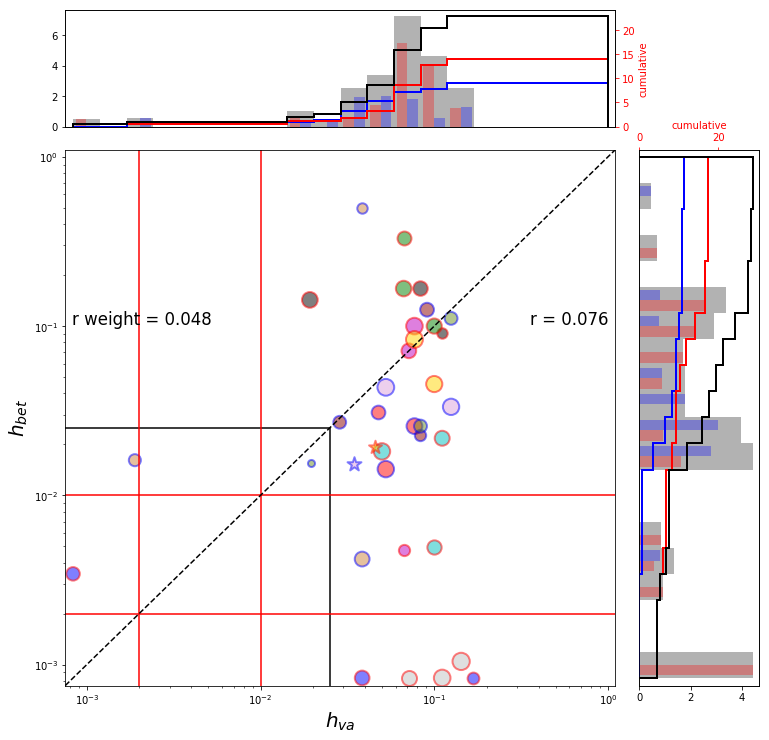

In [12]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
plot_fig(recording)